# MobileNet Analysis

In [1]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats as stats
from pathlib import Path
from commands.datastore import Datastore
from experiments.mobilenet.experiment import MobilenetExperiment
import circuit.extract as circuit_extractor
from parse import parse
from notebook_utils import get_model_metrics, get_mobilenet_output_count, get_mobilenet_layer_number, is_pareto_efficient_simple, examine_mean_hypothesis, examine_anova

sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True,
})

data_store = Datastore().derive("mobilenet")
figures = data_store / "figures"
figures.mkdir(exist_ok=True, parents=True)
uber_stats_file = data_store / "metrics.merged.csv.gz"

def get_parent_experiement():
    return MobilenetExperiment.with_data_only(data_store)

fitness_columns = ["Error", "Energy", "Area", "Delay", "Gate Count"]
quantized_columns = ["Error", "Quantized Energy", "Quantized Delay"]

sns.set_palette("deep")
sns.color_palette("deep")

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [2]:
def create_df(path: str = data_store, best_solution=False, **kwargs) -> pd.DataFrame:
    path = Path(path)
    root_experiment = get_parent_experiement()
    for experiment in root_experiment.get_experiments_with_glob("*_50_10"):
        name = experiment.get_name(depth=1)
        result = parse("{layer_name}_to_{layer_name2}_mse_{mse}_{rows}_{cols}", name)                
        if result is not None:
            mse = float(result["mse"])
            
            for f in experiment.get_train_statistics():
                csv = pd.read_csv(f)
                csv["mse_threshold"] = mse
                csv["experiment"] = name
                csv["error"] = csv["error"] / get_mobilenet_output_count(result["layer_name"])
                
                if best_solution:
                    yield csv.tail(n=1)
                else:
                    yield csv

def create_with_model_df(path: str = data_store, best_solution=False, **kwargs) -> pd.DataFrame:
    path = Path(path) / "model_metrics"
    dataset = "default"
    split = "validation"
    for f in os.listdir(path):
        result = parse("{dataset}.{split}.{layer_name}_to_{layer_name2}_mse_{mse}_{rows}_{cols}.{run}.csv", f)                
        if result is not None:
            mse = float(result["mse"])
            csv = pd.read_csv(path / f)
            csv["mse_threshold"] = mse
            csv["mse_threshold"] = csv["mse_threshold"].astype("category")
            csv["experiment"] = "{layer_name}_to_{layer_name2}_mse_{mse}_{rows}_{cols}".format(**result.named)
            csv["error"] = csv["error"] / get_mobilenet_output_count(result["layer_name"])
            metrics = get_model_metrics("mobilenetv2", result["dataset"], split)
            csv["ref top-1"] = metrics["top-1"]
            csv["ref top-5"] = metrics["top-5"]
            csv["ref loss"] = metrics["loss"]
            csv["dataset"] = result["dataset"].upper() + ", " + split
            
            if best_solution:
                yield csv.tail(n=1)
            else:
                yield csv
        else:
            raise ValueError(f"unknown file: {f}")
  

def get_gate_parameters(glob: str = None, record: pd.Series = None) -> pd.DataFrame:
    root_experiment = get_parent_experiement()
    experiment = next(root_experiment.get_experiments_with_glob(glob)) if record is None else root_experiment.get_experiment(record["Experiment"], from_filesystem=True)
    parameters_df = pd.read_csv(experiment.gate_parameters_csv_file)
    
    parameters_df.rename(columns={ parameters_df.columns[0]: "Function Name" }, inplace = True)
    parameters_df["Function Id"] = parameters_df["Function Name"].map(circuit_extractor.key_order)
    parameters_df.dropna(subset="Function Id", inplace=True)
    parameters_df["Function Id"] = parameters_df["Function Id"].astype("int")
    return parameters_df.sort_values(by="Function Id")
        
            
def get_gate_statistics(record: pd.Series) -> pd.DataFrame:
    root_experiment = get_parent_experiement()
    f = record["Experiment"]
    experiment = root_experiment.get_experiment(f, from_filesystem=True)
    gate_df = pd.read_csv(experiment.base_folder / "gate_statistics" / (f"statistics.{record['Run']}.{record['Run Id']}.txt"))
    # gate_df["Function Name"] = gate_df["Function"].map(dict((v, k) for k, v in circuit_extractor.key_order_with_id.items()))
    
    parameters_df = get_gate_parameters(record=record)
    gate_df = gate_df.sort_values(by="Function")
    merged_df = gate_df.merge(parameters_df, left_on="Function", right_on="Function Id", how="left")
    merged_df.reset_index(inplace=True)
    for attribute in ["Energy", "Area", "Power", "Delay"]:
        merged_df[attribute] = merged_df[attribute.lower()] * merged_df["Quantity"]
    # merged_df["Function Name"] = merged_df["Function Name"].astype("category")
    
    function_mapping = {
        "add": r"$a + b$",
        "sub": r"$a - b$",
        "mul": r"$a \cdot b$",
        "bit_and": r"$a \odot b$",
        "bit_or": r"$a \mathbin{|} b$",
        "bit_xor": r"$a \oplus b$",
        "bit_dec": r"$a - 1$",
        "bit_inc": r"$a + 1$",
        "reverse_max_a": r"$127 - a$",
        "reverse_min_b": r"$-128 + a$",
        "expected_value_max": r"$127$",
        "expected_value_min": r"$-128$",
        "minus_one_const": r"$-1$",
        "zero_const": r"$0$",
        "one_const": r"$1$",
        "neg": r"$-a$",
        "bit_neg": r"$\mathord{\sim}a$",
        **dict([(f"r_shift_{i}", f"$a \\gg {i}$") for i in range(1, 8)]),
        **dict([(f"l_shift_{i}", f"$a \\ll {i}$") for i in range(1, 8)]),
        "quarter": f"$a \\gg 2$",
        "half": f"$a \\gg 1$",
        "double": f"$a \\ll 1$",
        "mux_2to1": "MX",
        "mux_4to1": "D-MX",
    }

    merged_df["Function Name"] = merged_df["Function Name"].apply(lambda name: function_mapping.get(name, name))
    
    return merged_df

def get_weights(experiment: str):
    weights = data_store / experiment / "train.data"
    
    x = y = None
    with open(weights, "r") as f:
        lines = f.readlines()    
        x = [int(segment) for segment in lines[0].split(" ")]
        y = [int(segment) for segment in lines[1].split(" ")]
    return x, y

def load_dfs(path: str = data_store, best_solution=False, model_acc=False, unique=False):
    func = create_df if not model_acc else create_with_model_df
    df = pd.concat([df for df in func(path, best_solution=best_solution)], ignore_index=True)
    df.drop(columns="depth", inplace=True, errors="ignore")
    df.columns = df.columns.str.replace("_", " ").str.title()
    df.rename(columns={"Mse Threshold": "MSE Threshold"}, inplace=True)
    if unique:
        return df.loc[df["Dataset"] == "DEFAULT, validation"]
    else:
        return df

df = None
solutions_df = None
non_duplicate_df = None

### Load Data

In [3]:
df = df if df is not None else pd.read_csv(uber_stats_file) if uber_stats_file.exists() else load_dfs(best_solution=True, model_acc=True, unique=True)
df.describe()

if not uber_stats_file.exists():
    print("created uber statis file: " + str(uber_stats_file))
    df.to_csv(uber_stats_file, index=False)

### Evolution Progress

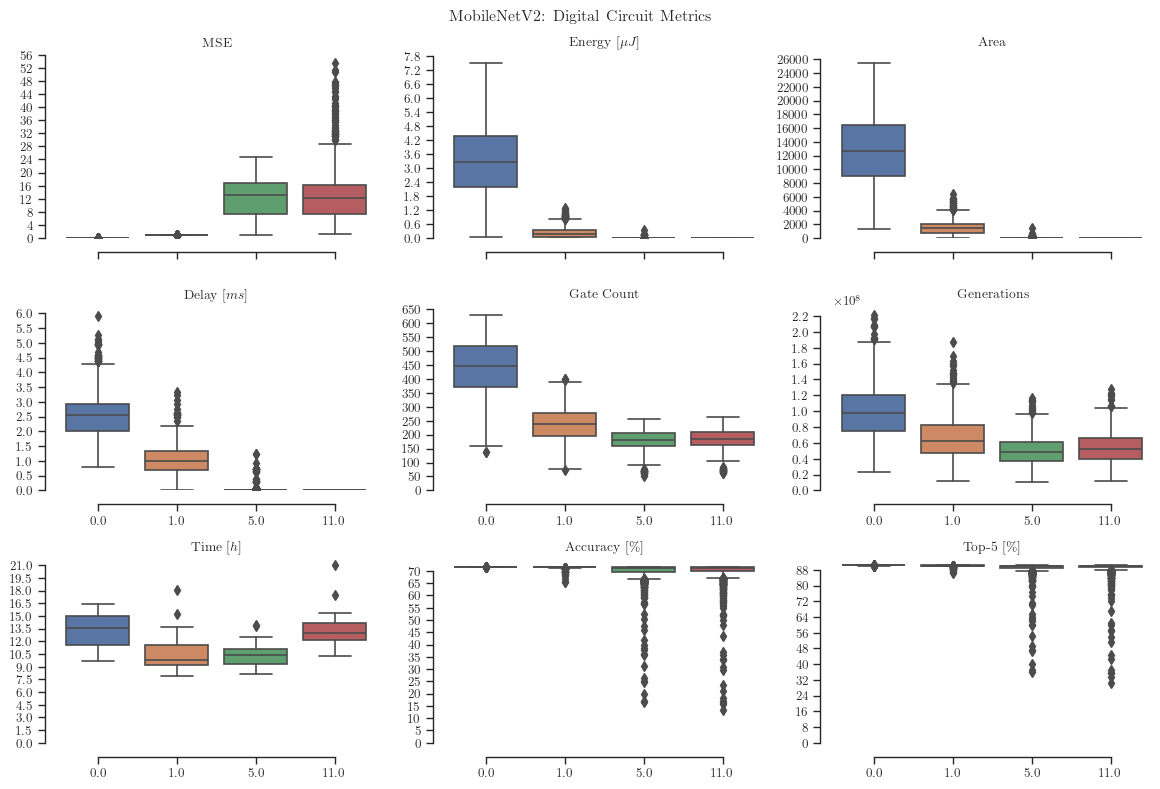

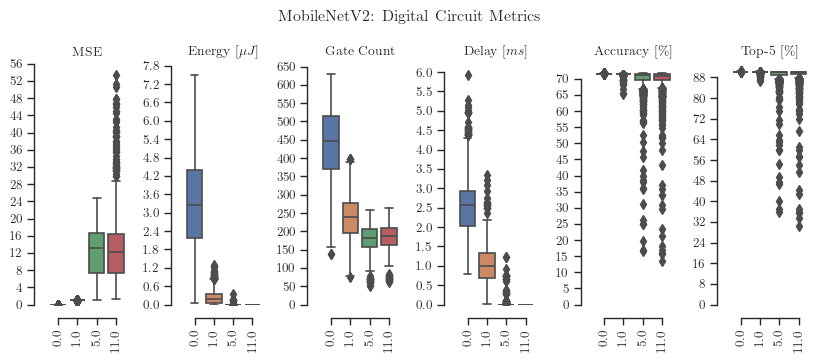

In [4]:
sns.set_theme(context="paper", font="qhv", style="ticks", rc={
    "text.usetex" : True,
})

titles = {
    "Error": r"MSE",
    "Energy": "Energy [$\mu J$]",
    "Area": "Area",
    "Delay": "Delay [$ms$]",
    "Gate Count": "Gate Count",
    "Generation": "Generations",
    "Timestamp": "Time $[h]$",
    "Top-1": "Accuracy [$\%$]",
    "Top-5": "Top-5 [$\%$]",
}

def plot(solutions_df, col, ax, i, sharex_index=True, landscape=False):
    tick_count = min((solutions_df["Gate Count"].max() + 1) // (2 if (col != "Gate Count") else 1), 15)
    if col == "Timestamp":
        solutions_df = solutions_df.groupby(by=["MSE Threshold", "Run"])["Timestamp"].max().reset_index()        
        solutions_df["Timestamp"] = solutions_df["Timestamp"] / 3600
    g = sns.boxplot(data=solutions_df, x="MSE Threshold", y=col, ax=ax)
    g.yaxis.set_major_locator(plt.MaxNLocator(tick_count, min_n_ticks=10, integer=(col=="Gate Count")))
    g.set_ylim(0)
    g.set_title(titles[col])
    g.set_ylabel(None)
    g.set_xlabel(None)
    if not landscape:
        g.tick_params(axis="x", rotation=90)
    if i < sharex_index:
        g.axes.get_xaxis().set_ticklabels([])
        g.set_xlabel(None)
    return g    

def plot_columns(df, columns, r, c, sharex=True, landscape=False):
    fig, axes = plt.subplots(r, c, figsize=(8.27 if not landscape else 11.69, 3.65 * r if not landscape else 8))
    for col, ax, i in zip(columns, axes.flat, range(r*c)):
        plot(df, col, ax, i, c if sharex else 0, landscape=landscape)    
    return fig

for x in ["best"]:
    solutions_df = df.copy()
    solutions_df["Top-1"] = solutions_df["Top-1"] * 100
    solutions_df["Top-5"] = solutions_df["Top-5"] * 100
    fig_all = plot_columns(solutions_df, fitness_columns + ["Generation", "Timestamp", "Top-1", "Top-5"], 3, 3, landscape=True)
    fig_all.suptitle("MobileNetV2: Digital Circuit Metrics")
    sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_all)
    fig_all.tight_layout()
    fig_all.savefig(figures / f"boxplot.{x}.png")
    fig_all.savefig(figures / f"boxplot.{x}.pdf")
    fig_all.savefig(figures / f"boxplot.{x}.svg")

    fig_brief = plot_columns(solutions_df, ["Error", "Energy", "Gate Count", "Delay", "Top-1", "Top-5"], 1, 6, sharex=False)
    sns.despine(offset=10, bottom=False, left=False, trim=True, fig=fig_brief)
    fig_brief.suptitle("MobileNetV2: Digital Circuit Metrics")
    fig_brief.tight_layout()
    fig_brief.savefig(figures / f"boxplot_{x}_brief.png")
    fig_brief.savefig(figures / f"boxplot_{x}_brief.pdf")
    fig_brief.savefig(figures / f"boxplot_{x}_brief.svg")

### Layer Accuracies DataFrame Setup

In [5]:
# init variables

def layer_extract(experiment_name: str) -> str:
    result = parse("{layer_name}_to_{layer_name2}_mse_{mse}_{rows}_{cols}", experiment_name)
    return result["layer_name"]

layer_df = df.copy()
layer_df["Layer"] = layer_df["Experiment"].apply(layer_extract)
layer_df = layer_df.sort_values(by="MSE Threshold", ascending=False)
layer_df["MSE Threshold"] = layer_df["MSE Threshold"].astype("string")
layer_df["Layer Index"] = layer_df["Layer"].apply(get_mobilenet_layer_number)
layer_df["Accuracy Loss"] = (layer_df["Ref Top-1"] - layer_df["Top-1"]) * 100
mse_order = ["0.0", "1.0", "5.0", "11.0"]
#layer_df.loc[layer_df["Accuracy Loss"] >= 1e-3, :]

### Plot Layer Boxplots

To explore energies consumption and accuracy losses per layer.

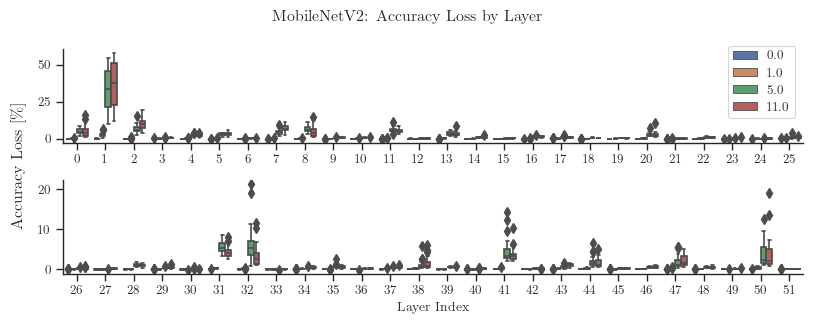

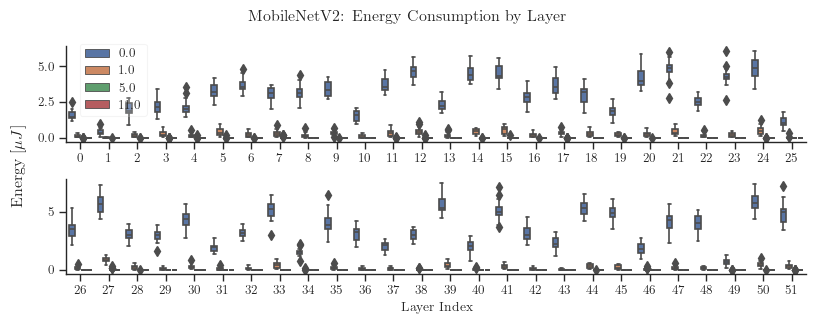

In [6]:
# plot boxplots
plot_df = layer_df.copy()

fig, ax = plt.subplots(2, 1, figsize=(8.27, 3.25))
g1 = sns.boxplot(data=plot_df.loc[plot_df["Layer Index"] <= 25], x="Layer Index", y="Accuracy Loss", hue="MSE Threshold", dodge=True, ax=ax[0], hue_order=mse_order)
g1.set(xlabel=None, ylabel=None)
g1.legend(loc="center left", bbox_to_anchor=(0.89, 0.65), ncol=1)
g2 = sns.boxplot(data=plot_df.loc[plot_df["Layer Index"] > 25], x="Layer Index", y="Accuracy Loss", hue="MSE Threshold", dodge=True, ax=ax[1], hue_order=mse_order)
g2.set(ylabel=None)
g2.legend_.remove()
fig.supylabel(r"Accuracy Loss [$\%$]")
fig.suptitle("MobileNetV2: Accuracy Loss by Layer")
fig.tight_layout()
sns.despine()
fig.savefig(figures / "boxplot_acc.pdf")

fig, ax = plt.subplots(2, 1, figsize=(8.27, 3.25))
g = sns.boxplot(data=plot_df.loc[plot_df["Layer Index"] <= 25], x="Layer Index", y="Energy", hue="MSE Threshold", dodge=True, ax=ax[0], hue_order=mse_order)
g.set(xlabel=None, ylabel=None)
g.legend(loc="center left", bbox_to_anchor=(0.01, 0.65), ncol=1, framealpha=0.2)
g = sns.boxplot(data=plot_df.loc[plot_df["Layer Index"] > 25], x="Layer Index", y="Energy", hue="MSE Threshold", dodge=True, ax=ax[1], hue_order=mse_order)
g.set(ylabel=None)
g.legend_.remove()
fig.supylabel(r"Energy [$\mu J$]")
fig.suptitle("MobileNetV2: Energy Consumption by Layer")
fig.tight_layout()
sns.despine()
fig.savefig(figures / "boxplot_energy.pdf")

In [7]:
def plot_pareto(title: str = None, layer_index: int = None, epsilon_a = 0.197, epsilon_e = 1e-5, fig=None, ax=None, suptitle=False):
    assert (fig is None and ax is None) or (fig is not None and ax is not None)
    temp_df = layer_df if layer_index is None else layer_df.loc[layer_df["Layer Index"] == layer_index]
    pareto = is_pareto_efficient_simple(np.vstack((temp_df["Accuracy Loss"], temp_df["Energy"])).T)
    scatter_df = temp_df.copy()
    scatter_df["Accuracy Loss"] += epsilon_a
    scatter_df["Energy"] += epsilon_e

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8.27, 3.25))

    sns.lineplot(data=scatter_df.loc[pareto, :], x="Energy", y="Accuracy Loss", linestyle="--", color="#555", lw=0.7, alpha=0.8, ax=ax)    
    g1 = sns.scatterplot(data=scatter_df, x="Energy", y="Accuracy Loss", hue="MSE Threshold", s=15, ax=ax, hue_order=mse_order)
    g1.set(yscale="log", xscale="log", xlabel=r"Energy $[\mu J] + \varepsilon$", ylabel=r"Accuracy Loss $[\%] + \varepsilon$")

    # g2.set_yticks([ref_acc - (t - epsilon_a) for t in g1.get_yticks()])
    # print([ref_acc - (t - epsilon_a) for t in g1.get_yticks() if ref_acc - (t - epsilon_a) >= 0])
    if not suptitle:
        g.set_title(title or f"MobileNetV2: Discovered Solutions on Layer {layer_index}")
    else:
        fig.suptitle(title or f"MobileNetV2: Discovered Solutions on Layer {layer_index}")
    sns.despine()
    return temp_df[["Accuracy Loss", "Energy"]].min()

### Global Pareto

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


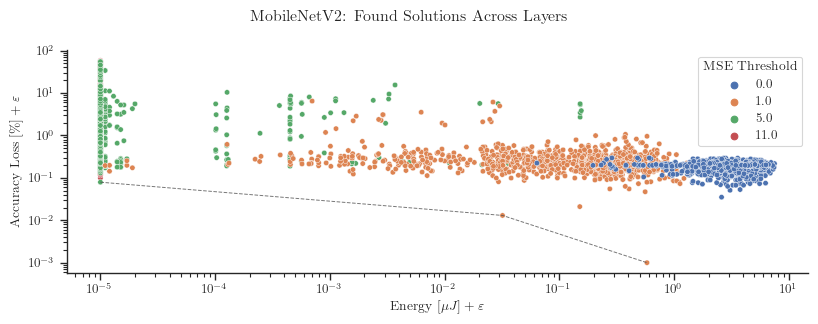

In [8]:
# plot accuracy energy
fig, ax = plt.subplots(1, 1, figsize=(8.27, 3.25))
a = plot_pareto("MobileNetV2: Found Solutions Across Layers", suptitle=True, fig=fig, ax=ax)
fig.tight_layout()
fig.savefig(figures / "global_pareto.pdf")
# for t in mse_order:
#     print(f"Testing Error {t}:", stats.pearsonr(layer_df.loc[layer_df["MSE Threshold"] == t, "Error"], layer_df.loc[layer_df["MSE Threshold"] == t, "Accuracy Loss"], alternative="greater"))    
    

### Threshold Accuracy Similarity Hypothesis Testing

In [9]:
x, y = examine_anova(*[layer_df.loc[layer_df["MSE Threshold"] == t, "Accuracy Loss"] for t in mse_order])
print(x)
print(y)

Result: HA , Hypotheses: H0: equal; HA: not equal, KruskalResult(statistic=2436.035643448634, pvalue=0.0)
KruskalResult(statistic=2436.035643448634, pvalue=0.0)
              1             2        3        4
1  1.000000e+00  2.157697e-77  0.00000  0.00000
2  2.157697e-77  1.000000e+00  0.00000  0.00000
3  0.000000e+00  0.000000e+00  1.00000  0.74043
4  0.000000e+00  0.000000e+00  0.74043  1.00000


### Threshold Energy Similarity Hypothesis Testomg

In [10]:
x, y = examine_anova(*[layer_df.loc[layer_df["MSE Threshold"] == t, "Energy"] for t in mse_order])
print(x)
print(y)

Result: HA , Hypotheses: H0: equal; HA: not equal, KruskalResult(statistic=3862.8170373943144, pvalue=0.0)
KruskalResult(statistic=3862.8170373943144, pvalue=0.0)
     1    2             3             4
1  1.0  0.0  0.000000e+00  0.000000e+00
2  0.0  1.0  0.000000e+00  0.000000e+00
3  0.0  0.0  1.000000e+00  1.680906e-40
4  0.0  0.0  1.680906e-40  1.000000e+00


#### Theshold 0 Outperforms Threshold 1 in Accuracy Hypothesis Testing

In [11]:
examine_mean_hypothesis(layer_df, "0.0", "1.0", variable="Accuracy Loss", df_column="MSE Threshold")

Result: HA , Hypotheses: H0: Accuracy Loss[0.0] == Accuracy Loss[1.0]; HA: Accuracy Loss[0.0] < Accuracy Loss[1.0], samples = 1040: MWU, MannwhitneyuResult(statistic=300276.5, pvalue=2.347768349874062e-69)


MannwhitneyuResult(statistic=300276.5, pvalue=2.347768349874062e-69)

### Theshold 1 Outperforms Threshold 0 in Energy Hypothesis Testing

In [12]:
examine_mean_hypothesis(layer_df, "1.0", "0.0", variable="Energy", df_column="MSE Threshold")

Result: HA , Hypotheses: H0: Energy[1.0] == Energy[0.0]; HA: Energy[1.0] < Energy[0.0], samples = 1040: MWU, MannwhitneyuResult(statistic=7722.0, pvalue=0.0)


MannwhitneyuResult(statistic=7722.0, pvalue=0.0)

### Closer Look at Layers 1 and 2

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

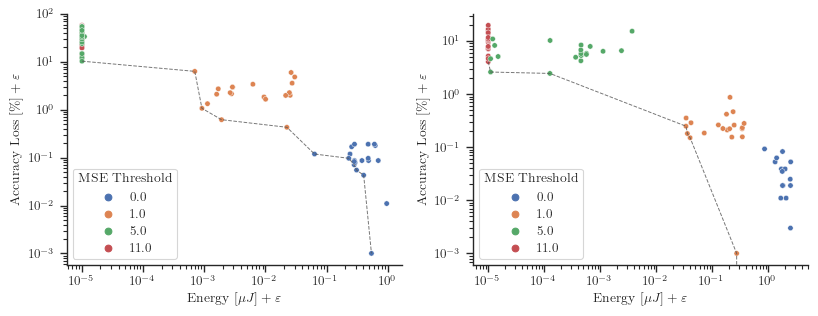

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(8.27, 3.25))
plot_pareto(layer_index=1, epsilon_a=0.093, fig=fig, ax=ax[0])
plot_pareto(layer_index=2, epsilon_a=0.077, fig=fig, ax=ax[1])
fig.tight_layout()
fig.savefig(figures / "pareto_1_32.pdf")

### Mean Hypothesis Threshold 5 and 11

In Layer 1 both thresholds are not significantly different in both metrics, however in layer 2 threshold 11 is significantly better in energy use.
Also, theshold 0 is significantly more accurate than theshold 1, however it is worse in energy utilisation.

In [14]:

for layer in [1, 2]:
    print(f"Examinating layer {layer}:")
    layer_2_df = layer_df.loc[layer_df["Layer Index"] == layer, :]

    x, y = examine_anova(*[layer_2_df.loc[layer_2_df["MSE Threshold"] == t, "Accuracy Loss"] for t in mse_order])
    print("Acc loss")
    print(x)
    print(y)

    x, y = examine_anova(*[layer_2_df.loc[layer_2_df["MSE Threshold"] == t, "Energy"] for t in mse_order])
    print("Energy")
    print(x)
    print(y)

    examine_mean_hypothesis(layer_2_df, "11.0", "5.0", variable="Accuracy Loss", df_column="MSE Threshold")
    examine_mean_hypothesis(layer_2_df, "11.0", "5.0", variable="Energy", df_column="MSE Threshold")

    examine_mean_hypothesis(layer_2_df, "0.0", "1.0", variable="Accuracy Loss", df_column="MSE Threshold")
    examine_mean_hypothesis(layer_2_df, "0.0", "1.0", variable="Energy", df_column="MSE Threshold", alternative="greater")

Examinating layer 1:
Result: HA , Hypotheses: H0: equal; HA: not equal, KruskalResult(statistic=66.96089046234648, pvalue=1.9090813650775852e-14)
Acc loss
KruskalResult(statistic=66.96089046234648, pvalue=1.9090813650775852e-14)
              1             2             3             4
1  1.000000e+00  1.763823e-09  1.001191e-26  8.919341e-29
2  1.763823e-09  1.000000e+00  9.905160e-15  3.040993e-17
3  1.001191e-26  9.905160e-15  1.000000e+00  1.863257e-01
4  8.919341e-29  3.040993e-17  1.863257e-01  1.000000e+00
Result: HA , Hypotheses: H0: equal; HA: not equal, KruskalResult(statistic=75.418610816543, pvalue=2.9470271415860864e-16)
Energy
KruskalResult(statistic=75.418610816543, pvalue=2.9470271415860864e-16)
              1             2             3             4
1  1.000000e+00  1.370009e-21  8.411963e-47  2.025239e-47
2  1.370009e-21  1.000000e+00  1.530151e-31  1.810995e-32
3  8.411963e-47  1.530151e-31  1.000000e+00  5.070040e-01
4  2.025239e-47  1.810995e-32  5.070040e-01  1.

In [15]:
zero_threshold_df = layer_df.loc[layer_df["MSE Threshold"] == "0.0", :].copy()
for index, row in zero_threshold_df.iterrows():
    x, y = get_weights(row["Experiment"])
    x = np.unique(x)
    y = np.unique(y)
    different = np.setdiff1d(y, x, assume_unique=False)
    zero_threshold_df.loc[index, "X"] = len(x)
    zero_threshold_df.loc[index, "Y"] = len(y)
    zero_threshold_df.loc[index, "Different"] = len(different)

In [16]:
different_all_df = layer_df.copy()
for t in layer_df["MSE Threshold"].unique():
    for index, row in layer_df.loc[layer_df["MSE Threshold"] == t, :].iterrows():
        x, y = get_weights(row["Experiment"])
        x = np.unique(x)
        y = np.unique(y)
        different = np.setdiff1d(y, x, assume_unique=False)
        different_all_df.loc[index, "X"] = len(x)
        different_all_df.loc[index, "Y"] = len(y)
        different_all_df.loc[index, "Different"] = len(different)

### Missing Weights and Energy Relationship

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\statsmodels\robust\robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  warnings.warn('Estimated scale is 0.0 indicating that the most'
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\statsmodels\robust\robust_linear_model.py:288: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of th

,X,Y,Different
3493,59.0,176.0,117.0
2522,67.0,182.0,115.0
763,57.0,200.0,143.0
762,57.0,200.0,143.0
761,57.0,200.0,143.0
...,...,...,...
2176,55.0,219.0,164.0
2175,55.0,219.0,164.0
2174,55.0,219.0,164.0
2173,55.0,219.0,164.0


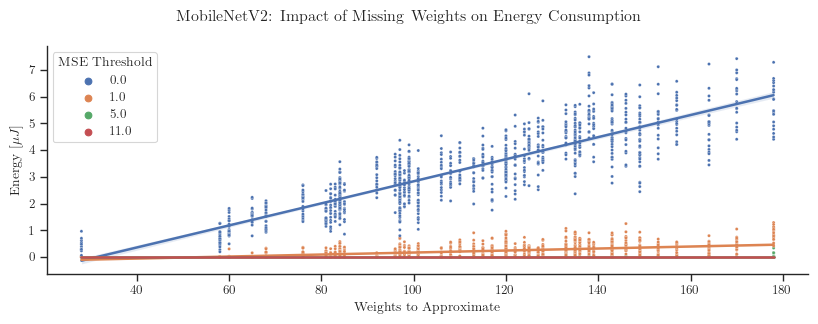

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8.27, 3.25))

for t, color in zip(mse_order, sns.color_palette()):
    g = sns.regplot(data=different_all_df.loc[different_all_df["MSE Threshold"] == t, :], x="Different", y="Energy", robust=True, ax=ax, scatter_kws={"s": 1}, line_kws={"color": color}, scatter=False)
g = sns.scatterplot(data=different_all_df, x="Different", y="Energy", s=5, hue="MSE Threshold", hue_order=mse_order, ax=ax)
g.set(ylabel=r"Energy $[\mu J]$", xlabel=r"Weights to Approximate")

# temp_df = different_all_df.copy()
# temp_df["Accuracy Loss"] += abs(temp_df["Accuracy Loss"].min()) + 0.01
# g = sns.scatterplot(data=temp_df, x="Different", y="Accuracy Loss", hue="MSE Threshold", hue_order=mse_order, ax=ax[1], s=5)
# g.set(ylabel=r"Accuracy Loss $[\%] + \varepsilon$", xlabel=r"Weights to Approximate", yscale="log")
# g.set_title("MobileNetV2: Accuracy Reliance on Missing Weights")
sns.despine()
fig.suptitle("MobileNetV2: Impact of Missing Weights on Energy Consumption")
fig.tight_layout()
fig.savefig(figures / "missing_weights.pdf")

different_all_df.loc[:, ["X", "Y", "Different"]]

### Weight Correlation Tests

Only energy testing is important here, as accuracy is influenced by another factors too.

In [18]:
for t in mse_order:
    print(f"Testing Accuracy {t}:", stats.pearsonr(different_all_df.loc[different_all_df["MSE Threshold"] == t, "Different"], different_all_df.loc[different_all_df["MSE Threshold"] == t, "Accuracy Loss"], alternative="less"))    
    print(f"Testing Energy {t}:", stats.pearsonr(different_all_df.loc[different_all_df["MSE Threshold"] == t, "Different"], different_all_df.loc[different_all_df["MSE Threshold"] == t, "Energy"], alternative="greater"))    

Testing Accuracy 0.0: PearsonRResult(statistic=-0.03300084844210827, pvalue=0.14383313221400548)
Testing Energy 0.0: PearsonRResult(statistic=0.8743060344878038, pvalue=0.0)
Testing Accuracy 1.0: PearsonRResult(statistic=-0.34249023048962945, pvalue=2.7045593740706116e-30)
Testing Energy 1.0: PearsonRResult(statistic=0.561511726924003, pvalue=9.303017129809612e-88)
Testing Accuracy 5.0: PearsonRResult(statistic=-0.34859609293749083, pvalue=2.210329738634044e-31)
Testing Energy 5.0: PearsonRResult(statistic=0.12081443429273744, pvalue=4.696143601823156e-05)
Testing Accuracy 11.0: PearsonRResult(statistic=-0.35813296863931426, pvalue=3.952842554463241e-33)
Testing Energy 11.0: PearsonRResult(statistic=nan, pvalue=nan)


c:\Users\Majo\.conda\envs\masters\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [19]:
def plot_weight_to_energy(threshold, threshold_title, acc=0, e=1):
    fig, ax1 = plt.subplots(1, 1, figsize=(8.27, 3))

    plot_df = different_all_df.loc[(different_all_df["MSE Threshold"] == threshold) & (different_all_df["Accuracy Loss"] <= acc) & (different_all_df["Error"] <= e), :]

    g1 = sns.barplot(data=plot_df, x="Layer Index", y="Different", ax=ax1, color=sns.color_palette()[0])
    g1.set(xlabel="Layer Index", ylabel=r"Weights to Approximate (Blue)")
    ax2 = ax1.twinx()

    energies_df = plot_df.groupby(by="Layer Index").min().reset_index()
    # energies_df["Energy"] += 1e-5
    g2 = sns.barplot(data=energies_df, x="Layer Index", y="Energy", ax=ax2, color=sns.color_palette()[1], alpha=0.75)
    g2.set(ylabel=r"Energy [$\mu J$]")
    sns.despine(ax=ax1, right=False)
    sns.despine(ax=ax2, left=False)

    fig.suptitle(f"MobileNetV2: Lowest Energy Consumption per Layer at Threshold {threshold_title}")
    fig.tight_layout()
    fig.savefig(figures / f"energy_missing_weights.{threshold_title}.{acc}.{e}.pdf")    

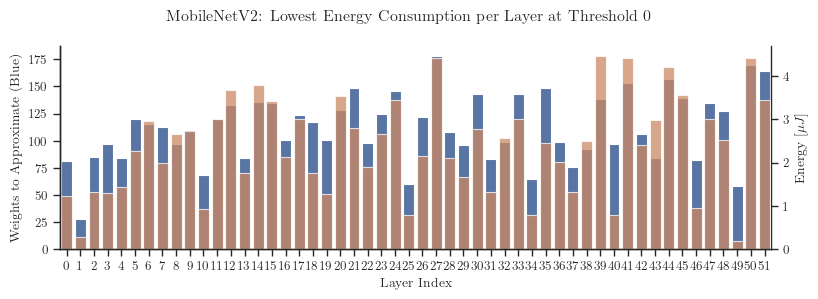

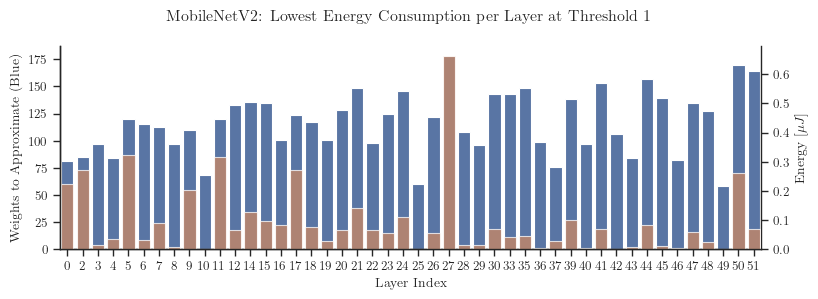

In [21]:
plot_weight_to_energy("0.0", "0")
plot_weight_to_energy("1.0", "1")
# plot_weight_to_energy("0.0", "0", e=1e12)
# plot_weight_to_energy("1.0", "1", e=1e12)

# plot_weight_to_energy("5.0", "5")
# plot_weight_to_energy("11.0", "11")

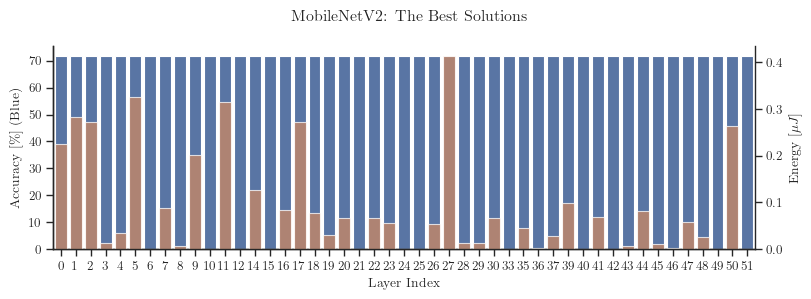

In [22]:
def plot_accuracy_to_energy(energy_t, acc_t):
    fig, ax1 = plt.subplots(1, 1, figsize=(8.27, 3))
    
    agg_df = different_all_df\
        .loc[(different_all_df["Energy"] <= energy_t) & (different_all_df["Accuracy Loss"] <= acc_t), :]\
        .sort_values(by=["Energy", "Accuracy Loss"])\
        .groupby(by="Layer Index").first().reset_index()
        
    agg_df["Accuracy"] = agg_df["Top-1"] * 100
    g1 = sns.barplot(data=agg_df, x="Layer Index", y="Accuracy", ax=ax1, color=sns.color_palette()[0])
    g1.set(xlabel="Layer Index", ylabel=r"Accuracy [$\%$] (Blue)")
    ax2 = ax1.twinx()

    # energies_df["Energy"] += 1e-5
    g2 = sns.barplot(data=agg_df, x="Layer Index", y="Energy", ax=ax2, color=sns.color_palette()[1], alpha=0.75)
    g2.set(ylabel=r"Energy [$\mu J$]")
    sns.despine(ax=ax1, right=False)
    sns.despine(ax=ax2, left=False)

    fig.suptitle(f"MobileNetV2: The Best Solutions")
    fig.tight_layout()
    fig.savefig(figures / f"accuracy_to_energy.{energy_t}.{acc_t}.pdf")
    
plot_accuracy_to_energy(0.75, 0)

In [23]:
print(stats.ttest_1samp(different_all_df.loc[different_all_df["Accuracy Loss"] <= 0, "Energy"], 30, alternative="less"))
different_all_df.loc[different_all_df["Accuracy Loss"] <= 0, "Energy"].describe()

TtestResult(statistic=-499.39809253973556, pvalue=0.0, df=1123)


count    1124.000000
mean        2.155768
std         1.869268
min         0.000000
25%         0.285609
50%         1.991814
75%         3.652600
max         7.417551
Name: Energy, dtype: float64

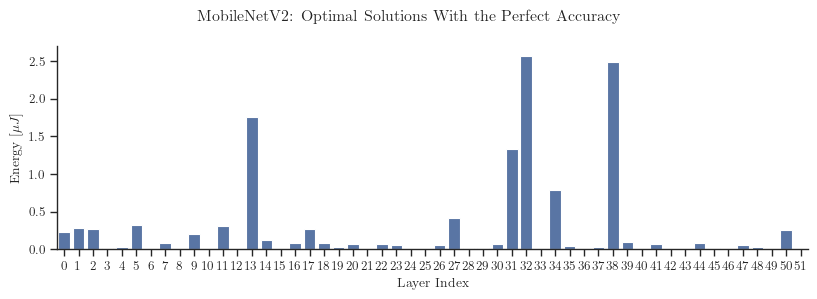

In [24]:

fig, ax1 = plt.subplots(1, 1, figsize=(8.27, 3))

agg_df = different_all_df\
    .loc[different_all_df["Accuracy Loss"] <= 0, :]\
    .sort_values(by=["Energy", "Accuracy Loss"])\
    .groupby(by="Layer Index").first().reset_index()
    
agg_df["Accuracy"] = agg_df["Top-1"] * 100
g1 = sns.barplot(data=agg_df, x="Layer Index", y="Energy", ax=ax1, color=sns.color_palette()[0])
g1.set(xlabel="Layer Index", ylabel=r"Energy [$\mu J$]")

sns.despine()
fig.suptitle(f"MobileNetV2: Optimal Solutions With the Perfect Accuracy")
fig.tight_layout()
fig.savefig(figures / f"best_solutions.pdf")

### Examining Outlier from Previous Lowest Energy Consumption Graphs

This layer exhibits very unusual solutions. It was discovered way too late to research it more.
It has to approximate 178 weights.

c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Majo\.conda\envs\masters\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Accuracy Loss   -0.124
Energy           0.000
dtype: float64


178.0

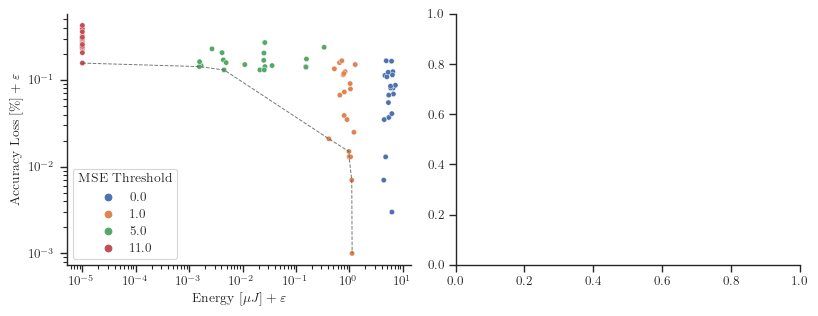

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(8.27, 3.25))
a = plot_pareto(layer_index=27, epsilon_a=0.125, fig=fig, ax=ax[0])
fig.tight_layout()
fig.savefig(figures / "pareto_27.pdf")
print(a)
different_all_df.loc[different_all_df["Layer Index"] == 27, "Different"].max()

### Energy Utilisation by 2 Opposite Thresholds (Discontinued)

C:\Users\Majo\AppData\Local\Temp\ipykernel_27376\4155331571.py:7: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  best_solution = filtered_df.loc[(different_all_df["Accuracy Loss"] <= 2) & (filtered_df["MSE Threshold"] == threshold), :].sort_values(by=["Energy", "Accuracy Loss"], ascending=[True, True]).iloc[0]


warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\features.9.conv.0.0_to_features.9.conv.0.0_mse_5.0_256_31.all.zip\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\figures\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\metrics.merged.csv.gz\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\model_metrics\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\features.9.conv.0.0_to_features.9.conv.0.0_mse_5.0_256_31.all.zip\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\figures\\train_cgp.config'
warn: 

C:\Users\Majo\AppData\Local\Temp\ipykernel_27376\4155331571.py:7: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  best_solution = filtered_df.loc[(different_all_df["Accuracy Loss"] <= 2) & (filtered_df["MSE Threshold"] == threshold), :].sort_values(by=["Energy", "Accuracy Loss"], ascending=[True, True]).iloc[0]


warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\features.9.conv.0.0_to_features.9.conv.0.0_mse_5.0_256_31.all.zip\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\figures\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\metrics.merged.csv.gz\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\model_metrics\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\features.9.conv.0.0_to_features.9.conv.0.0_mse_5.0_256_31.all.zip\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\figures\\train_cgp.config'
warn: 

C:\Users\Majo\AppData\Local\Temp\ipykernel_27376\4155331571.py:7: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  best_solution = filtered_df.loc[(different_all_df["Accuracy Loss"] <= 2) & (filtered_df["MSE Threshold"] == threshold), :].sort_values(by=["Energy", "Accuracy Loss"], ascending=[True, True]).iloc[0]


warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\features.9.conv.0.0_to_features.9.conv.0.0_mse_5.0_256_31.all.zip\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\figures\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\metrics.merged.csv.gz\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\model_metrics\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\features.9.conv.0.0_to_features.9.conv.0.0_mse_5.0_256_31.all.zip\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\figures\\train_cgp.config'
warn: 

C:\Users\Majo\AppData\Local\Temp\ipykernel_27376\4155331571.py:7: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  best_solution = filtered_df.loc[(different_all_df["Accuracy Loss"] <= 2) & (filtered_df["MSE Threshold"] == threshold), :].sort_values(by=["Energy", "Accuracy Loss"], ascending=[True, True]).iloc[0]


warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\features.9.conv.0.0_to_features.9.conv.0.0_mse_5.0_256_31.all.zip\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\figures\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\metrics.merged.csv.gz\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\model_metrics\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\features.9.conv.0.0_to_features.9.conv.0.0_mse_5.0_256_31.all.zip\\train_cgp.config'
warn: [Errno 2] No such file or directory: 'C:\\Users\\Majo\\source\\repos\\TorchCompresser\\data_store\\mobilenet\\figures\\train_cgp.config'
warn: 

C:\Users\Majo\AppData\Local\Temp\ipykernel_27376\4155331571.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["MSE Threshold"] = group["MSE Threshold"].astype(str)


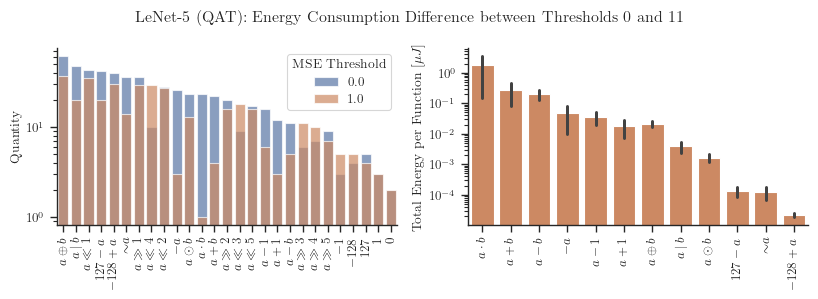

In [ ]:
thresholds = different_all_df["MSE Threshold"].unique()

best_solutions = []
filtered_df = different_all_df.loc[different_all_df["Layer Index"] == 27, :]

for i, threshold in enumerate(sorted(thresholds)):
    best_solution = filtered_df.loc[(different_all_df["Accuracy Loss"] <= 2) & (filtered_df["MSE Threshold"] == threshold), :].sort_values(by=["Energy", "Accuracy Loss"], ascending=[True, True]).iloc[0]
    best_gate_df = get_gate_statistics(record=best_solution).sort_values(by="Quantity")
    best_gate_df["MSE Threshold"] = str(threshold)
    best_solutions.append(best_gate_df)

plot_df = pd.concat(best_solutions)

def plot_pair(ax, *groups, energy_legend=False):
    group = plot_df.loc[plot_df["MSE Threshold"].isin(groups), :]
    group["MSE Threshold"] = group["MSE Threshold"].astype(str)

    quantity_df = group.loc[group["Quantity"] > 0, :].sort_values(by=["Quantity"], ascending=False)
    energy_df = group.loc[group["Energy"] > 0, :].sort_values(by=["Energy"], ascending=False)

    g = sns.barplot(data=quantity_df, x="Function Name", y="Quantity", hue="MSE Threshold", ax=ax[0], dodge=False, alpha=0.7)
    g.set(xlabel=None, yscale="log")
    sns.move_legend(g, "upper right")

    if energy_df.empty:
        return
        
    if not energy_legend:
        g = sns.barplot(data=energy_df, x="Function Name", y="Energy", color=sns.color_palette()[1], ax=ax[1], dodge=False)
    else:
        g = sns.barplot(data=energy_df, x="Function Name", y="Energy", hue="MSE Threshold", ax=ax[1], dodge=False)
    g.set(xlabel=None, yscale="log", ylabel=r"Total Energy per Function [$\mu J$]")

    

fig, ax = plt.subplots(1, 2, figsize=(8.27, 3))

plot_pair(ax, "0.0", "1.0")
for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
fig.suptitle("LeNet-5 (QAT): Energy Consumption Difference between Thresholds 0 and 11")
sns.despine()
fig.tight_layout()
# fig.savefig(figures / "energy_consumption_11_0.pdf")

### Accuracy and Error Dependence

Correlations were mixed, which is assumed to be cause by layer sensitivity and unpredictability at small errors.

0.0 less PearsonRResult(statistic=-0.084724917282789, pvalue=0.003129190111304221)
1.0 two-sided PearsonRResult(statistic=-0.04903639118462237, pvalue=0.11400953388665076)
5.0 greater PearsonRResult(statistic=0.10599159028946145, pvalue=0.0003089153665525347)
11.0 greater PearsonRResult(statistic=0.14589760967450888, pvalue=1.1522717292800806e-06)


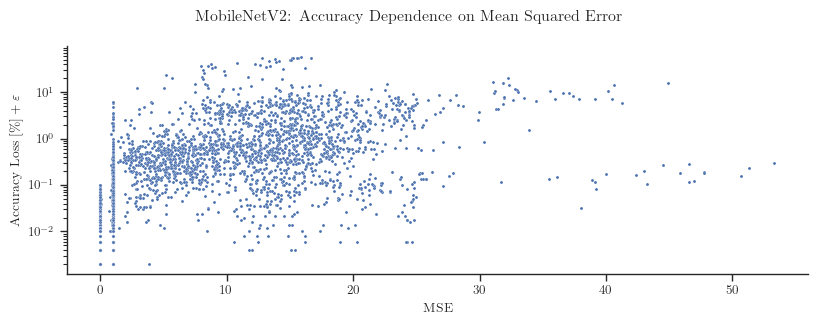

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8.27, 3.25))

error_to_acc = layer_df.copy()
error_to_acc["Accuracy Loss"] += abs(error_to_acc["Accuracy Loss"].min()) + 1e6
g = sns.scatterplot(data=layer_df, x="Error", y="Accuracy Loss", ax=ax, s=5)
# g = sns.scatterplot(data=zero_threshold_df, x="Different", y="Energy", s=10, ax=ax)
g.set(ylabel=r"Accuracy Loss $[\%] + \varepsilon$", xlabel=r"MSE")
g.set(yscale="log")
fig.suptitle("MobileNetV2: Accuracy Dependence on Mean Squared Error")
sns.despine()
fig.tight_layout()
fig.savefig(figures / "accuracy_error.pdf")

for t in mse_order:
    cat = different_all_df.loc[different_all_df["MSE Threshold"] == t, :]
    alternative = "greater" if t in ["5.0", "11.0"] else "less" if t == "0.0" else "two-sided"
    print(t, alternative, stats.pearsonr(cat["Error"], cat["Accuracy Loss"], alternative=alternative))

### Sensitivity Table

In [30]:
data = []
for layer_index in range(52):
    for t in layer_df["MSE Threshold"].unique():
        metrics = get_model_metrics("mobilenetv2", "default", "validation")
        temp_df = layer_df.loc[(layer_df["MSE Threshold"] == t) & (layer_df["Layer Index"] == layer_index), "Top-1"]
        res = stats.ttest_1samp(temp_df, metrics["top-1"] - 0.02, alternative="less")
        if res.pvalue < 0.05:
            data.append((layer_index, t, temp_df.mean() * 100, (metrics["top-1"] - temp_df.mean()) * 100))

temp_df = pd.DataFrame(data, columns=["Layer Index", "MSE Threshold", r"Mean Accuracy [$\%$]", r"Accuracy Loss [$\%$]"])
temp_df.index
table_df = pd.pivot(temp_df, columns="MSE Threshold", index="Layer Index", values=[r"Mean Accuracy [$\%$]", r"Accuracy Loss [$\%$]"])
table_df.to_latex()

'\\begin{tabular}{lrrrr}\n\\toprule\n & \\multicolumn{2}{r}{Mean Accuracy [$\\%$]} & \\multicolumn{2}{r}{Accuracy Loss [$\\%$]} \\\\\nMSE Threshold & 11.0 & 5.0 & 11.0 & 5.0 \\\\\nLayer Index &  &  &  &  \\\\\n\\midrule\n0 & 66.217300 & 66.829600 & 5.378700 & 4.766400 \\\\\n1 & 34.423000 & 38.881800 & 37.173000 & 32.714200 \\\\\n2 & 61.536100 & 65.015100 & 10.059900 & 6.580900 \\\\\n5 & 68.470400 & 68.716800 & 3.125600 & 2.879200 \\\\\n7 & 64.643700 & 67.023100 & 6.952300 & 4.572900 \\\\\n8 & 66.595400 & 65.343000 & 5.000600 & 6.253000 \\\\\n11 & 66.271700 & 65.730200 & 5.324300 & 5.865800 \\\\\n13 & 68.497500 & 68.106200 & 3.098500 & 3.489800 \\\\\n20 & NaN & 68.886100 & NaN & 2.709900 \\\\\n31 & 67.250300 & 66.034800 & 4.345700 & 5.561200 \\\\\n32 & 67.983700 & 65.029000 & 3.612300 & 6.567000 \\\\\n41 & 67.828900 & 66.813600 & 3.767100 & 4.782400 \\\\\n50 & 67.514700 & 67.596400 & 4.081300 & 3.999600 \\\\\n\\bottomrule\n\\end{tabular}\n'